In [4]:
import torch
import networkx as nx
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from torch import nn

# Building graphs

In [5]:
A0 = torch.randint(0, 2, (10, 10))
A1 = torch.randint(0, 2, (50, 50))

In [6]:
def build_graph(A):
    graph = nx.DiGraph()  # note nx.Graph() v.s. nx.DiGraph()
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] == 1:
                graph.add_edge(i, j)
            if i == j:  # adding self loop
                graph.add_edge(i, j)
    return graph

In [7]:
G0 = build_graph(A0)

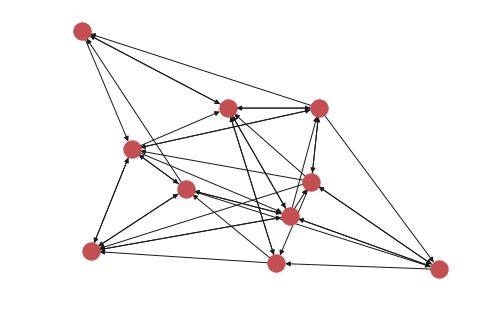

In [8]:
nx.draw(G0)

In [9]:
G1 = build_graph(A1)

In [10]:
def build_graph_batch(G_lst):
    lens = [len(G.nodes) for G in G_lst]
    n = max(lens)
    bsz = len(G_lst)
    indices = []
    values = []
    size = torch.Size((bsz * n, n))
    for b, G in enumerate(G_lst):
        base = b * n
        for edge in G.edges:
            i, j = edge
            indices.append((i+base, j))
            values.append(1)
    indices = torch.Tensor(indices).t()  # from (nnodes_total, 2) to (2, nnodes_total)
    values = torch.Tensor(values)
    adj = torch.sparse_coo_tensor(indices, values, size)
    adj_in = adj.to_dense().view(bsz, n, n)
    adj_out = adj_in.transpose(1, 2)
    return adj_in, adj_out, lens

In [11]:
adj_in, adj_out, lens = build_graph_batch([G0, G1])
lens

[10, 50]

In [12]:
bsz, n, n = adj_in.shape

# Simple GCN

# $\mathbf{h}_v^{(j+1)} = \rho\Big(\sum_{u\in\mathcal N(v)} \mathbf{W}_{\mathrm{dir}(u,v)}^{(j)}\mathbf{h}_u^{(j)}+\mathbf{b}_{\mathrm{dir}(u,v)}^{(j)}\Big)$

In [13]:
class GCNLayer(nn.Module):
    def __init__(self, hdim, bias=True):
        super(GCNLayer, self).__init__()
        self.prop = nn.Linear(hdim, 2 * hdim, bias=bias)  # 2 for in and out
        self.relu = nn.ReLU()
    
    def aggregate(self, hids, adj):
        # hids: (bsz, n, hdim)
        # adj: (bsz, n, n)
        hids_agged = torch.bmm(adj, hids)  # hids_agged: (bsz, n, hdim)
        return hids_agged
        
    def forward(self, adj_in, adj_out, hids):
        # adj_xxx: (bsz, n, n)
        # hids: (bsz, n, hdim)
        hids_pin, hids_pout = self.prop(hids).chunk(2, dim=-1)  # (bsz, n, hdim)
        hids_aggin = self.aggregate(hids_pin, adj_in)
        hids_aggout = self.aggregate(hids_pout, adj_out)  # hids_aggxx: (bsz, n, hdim)
        hids = self.relu(hids_aggin + hids_aggout) 
        return hids

In [14]:
def run_gcn(nlayers=10, bias=True):
    def scatter(hids):
        # hids: (bsz, n, hdim=2)
        x = hids[0, :, 0].detach()
        y = hids[0, :, 1].detach()
        plt.scatter(x, y)
        plt.show()
    
    hdim = 2    
    mgcn = nn.ModuleList([GCNLayer(hdim, bias) for _ in range(nlayers)])
    mgcn.train(False)
    
    hids = torch.randn(bsz, n, hdim)
    hids_lst = [hids]
    for gcn in mgcn:
        hids = gcn(adj_in, adj_out, hids)
        hids_lst.append(hids)
    for i, hids in enumerate(hids_lst):
        print(f'layer {i}:')
        scatter(hids)

layer 0:


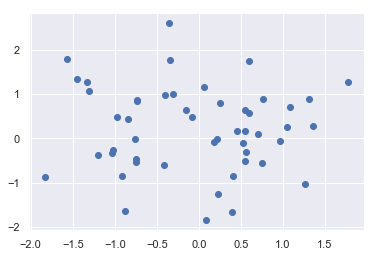

layer 1:


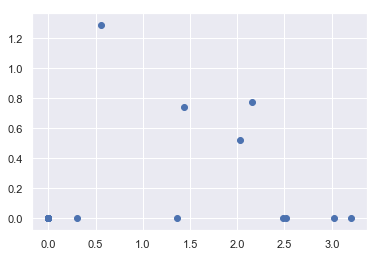

layer 2:


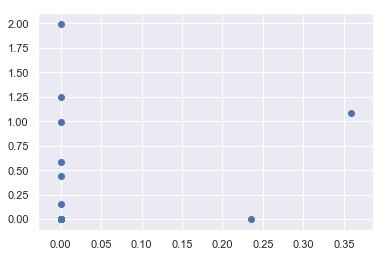

layer 3:


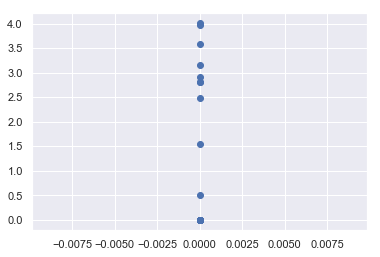

layer 4:


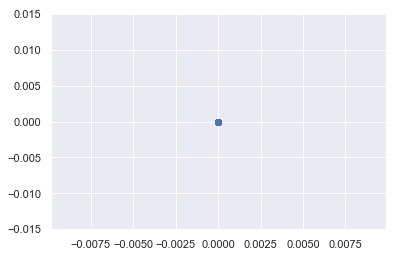

layer 5:


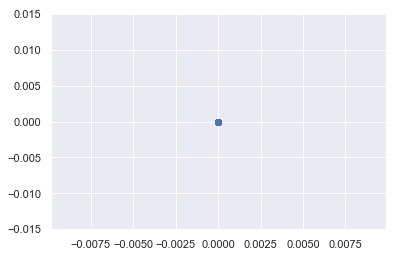

layer 6:


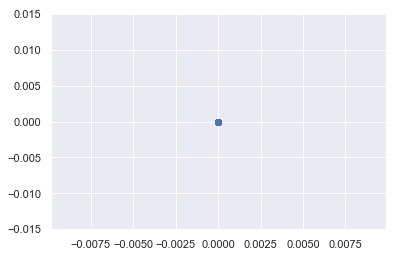

layer 7:


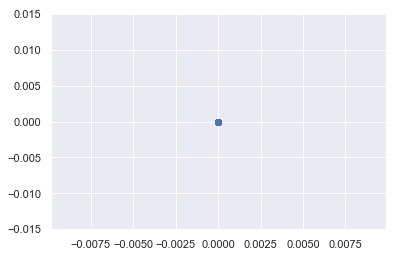

layer 8:


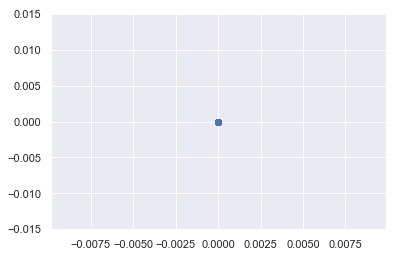

layer 9:


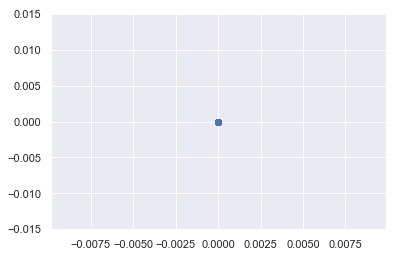

layer 10:


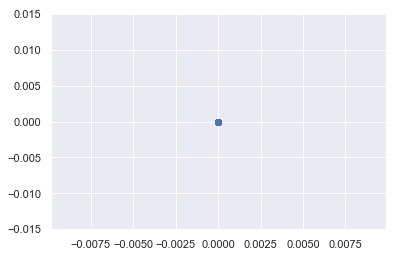

In [15]:
run_gcn(bias=False)

layer 0:


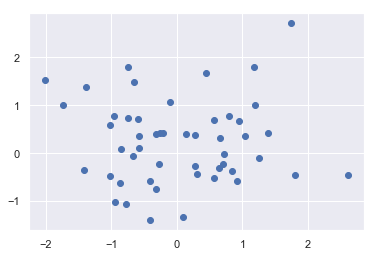

layer 1:


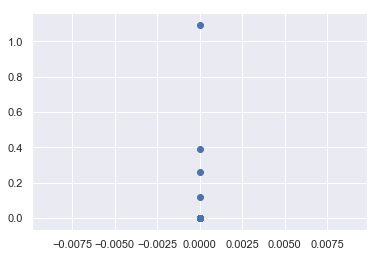

layer 2:


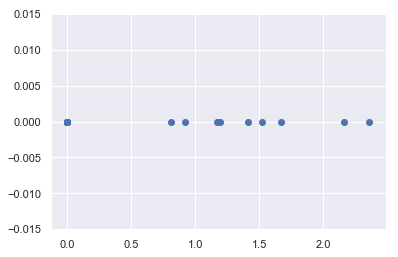

layer 3:


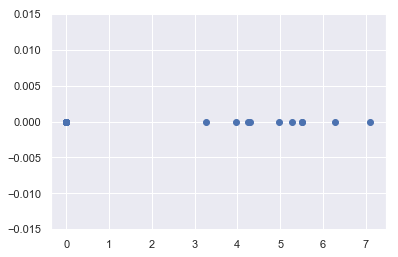

layer 4:


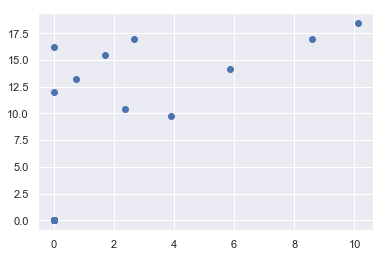

layer 5:


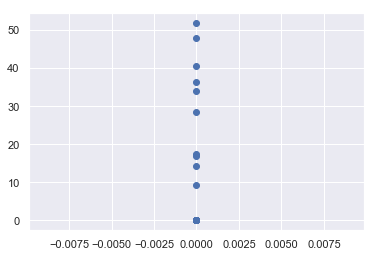

layer 6:


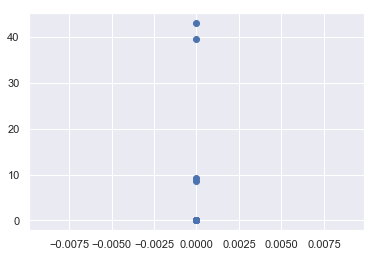

layer 7:


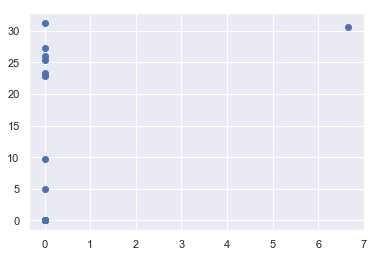

layer 8:


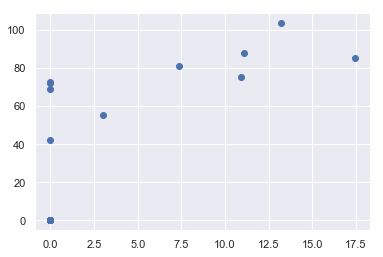

layer 9:


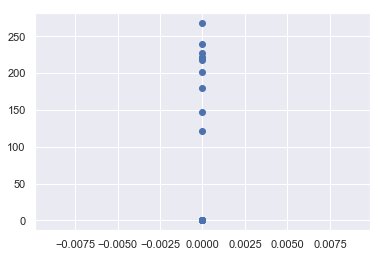

layer 10:


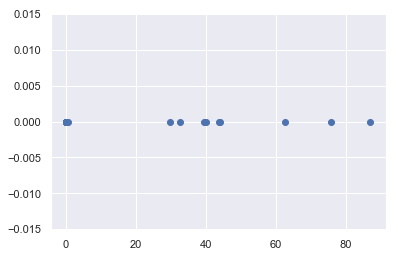

In [16]:
run_gcn(bias=True)

# Gated GCN

# $\mathbf{h}_v^{(j+1)} = \rho\Big(\sum_{u\in\mathcal N(v)} g_{u,v}^{(j)}\big(\mathbf{W}_{\mathrm{dir}(u,v)}^{(j)}\mathbf{h}_u+\mathbf{b}_{\mathrm{dir}(u,v)}^{(j)}\big)\Big)$

# $g_{u, v}^{(j)} = \sigma\Big(\mathbf{h}_u^{(j)}\cdot \hat{\mathbf{w}}_{\mathrm{dir}(u, v)}^{(j)}+ \hat{b}_{\mathrm{dir(u, v)}}^{(j)}\Big) $

In [18]:
class GatedGCNLayer(nn.Module):
    def __init__(self, hdim, drop, bias=True):
        super(GatedGCNLayer, self).__init__()
        self.prop = nn.Linear(hdim, 2 * hdim, bias=bias)  # 2 for in and out
        self.hid2gate = nn.Sequential(nn.Linear(hdim, 2, bias=bias), nn.Sigmoid())
        self.drop = drop
        self.relu = nn.ReLU()

    def edge_dropout(self, adj):
        probs_drop = adj.new_full(adj.shape, self.drop)
        emask = torch.bernoulli(probs_drop).byte()  # sample a mask
        adj.masked_fill_(emask, 0)  # apply masking
        if self.training:
            adj = adj / (1 - self.drop) # scaling only in training
        return adj
    
    def aggregate(self, hids, gate, adj):
        # hids: (bsz, n, hdim)
        # gate: (bsz, n, 1)
        # adj: (bsz, n, n)
        adj_gated = adj * gate.transpose(1, 2)
        # note this transpose: same between rows (nodes) , different between columns (neighbors: aggregated)
        hids_agged = torch.bmm(adj_gated, hids)  # hids_agged: (bsz, n, hdim)
        return hids_agged
        
    def forward(self, adj_in, adj_out, hids):
        # adj_xxx: (bsz, n, n)
        # hids: (bsz, n, hdim)
        hids_pin, hids_pout = self.prop(hids).chunk(2, dim=-1)  # (bsz, n, hdim)
        gin, gout = self.hid2gate(hids).chunk(2, dim=-1)  # (bsz, n , 1)
        hids_aggin = self.aggregate(hids_pin, gin, adj_in)
        hids_aggout = self.aggregate(hids_pout, gout, adj_out)  # hids_aggxx: (bsz, n, hdim)
        hids = self.relu(hids_aggin + hids_aggout) 
        return hids

In [19]:
def run_ggcn(nlayers=10, drop=0, bias=True):
    def scatter(hids):
        # hids: (bsz, n, hdim=2)
        x = hids[0, :, 0].detach()
        y = hids[0, :, 1].detach()
        plt.scatter(x, y)
        plt.show()
    
    hdim = 2    
    mgcn = nn.ModuleList([GatedGCNLayer(hdim, drop, bias) for _ in range(nlayers)])
    mgcn.train(False)
    
    hids = torch.randn(bsz, n, hdim)
    hids_lst = [hids]
    for gcn in mgcn:
        hids = gcn(adj_in, adj_out, hids)
        hids_lst.append(hids)
    for i, hids in enumerate(hids_lst):
        print(f'layer {i}:')
        scatter(hids)

layer 0:


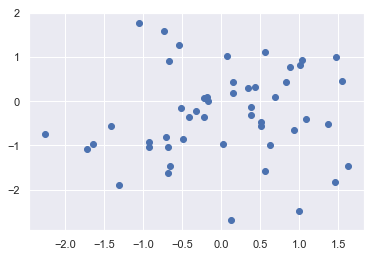

layer 1:


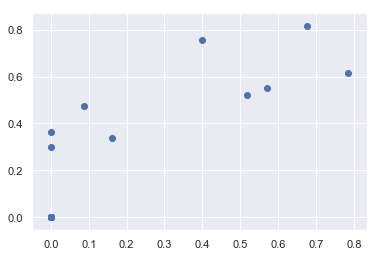

layer 2:


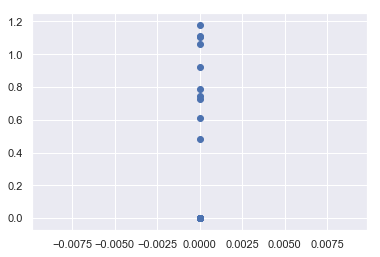

layer 3:


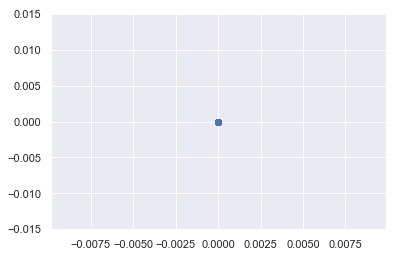

layer 4:


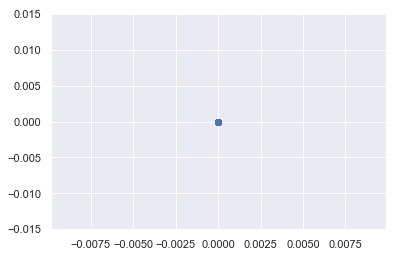

layer 5:


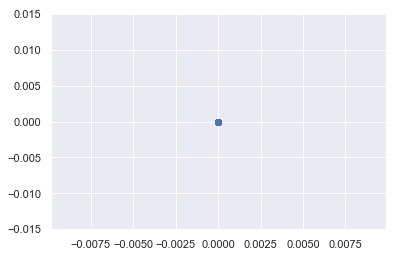

layer 6:


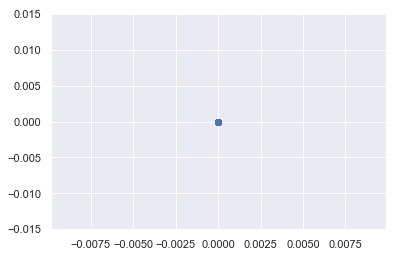

layer 7:


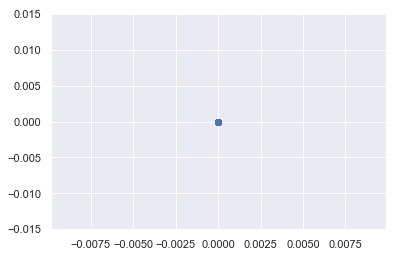

layer 8:


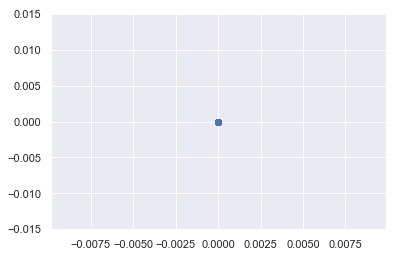

layer 9:


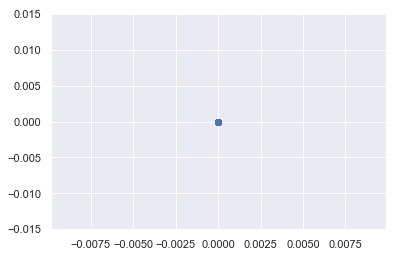

layer 10:


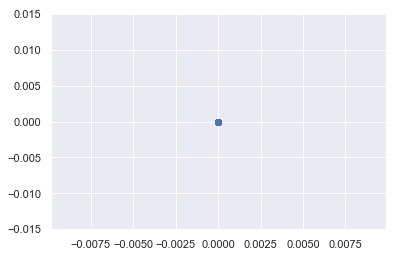

In [20]:
run_ggcn(drop=0, bias=False)

layer 0:


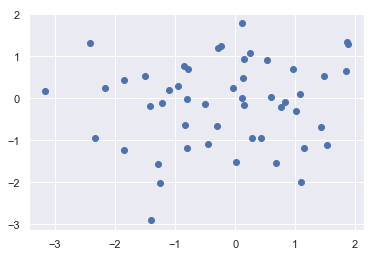

layer 1:


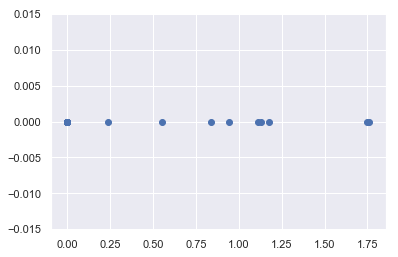

layer 2:


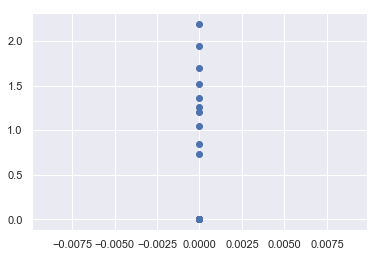

layer 3:


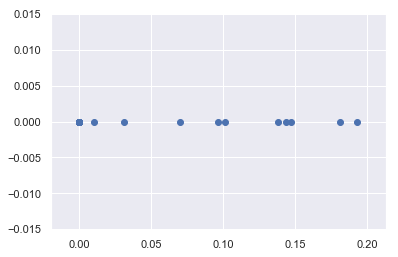

layer 4:


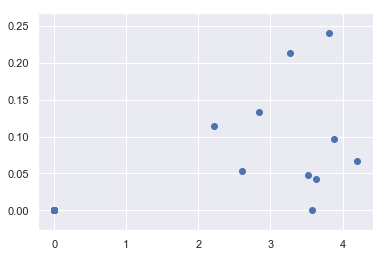

layer 5:


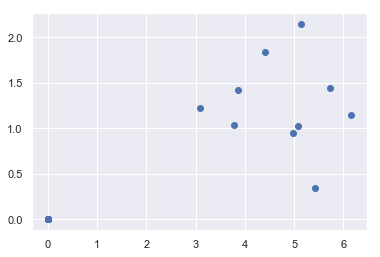

layer 6:


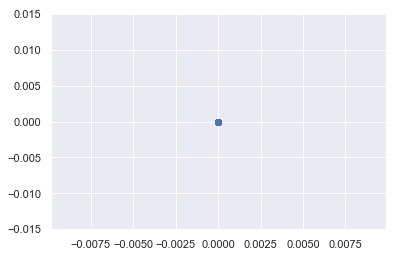

layer 7:


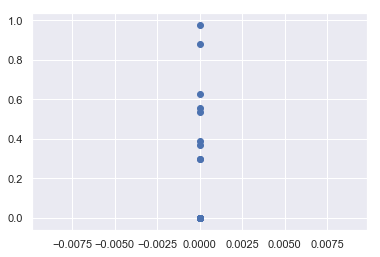

layer 8:


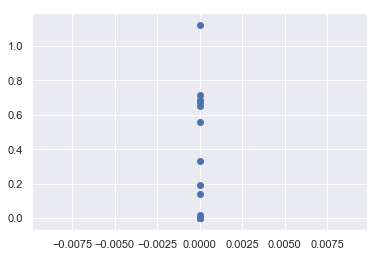

layer 9:


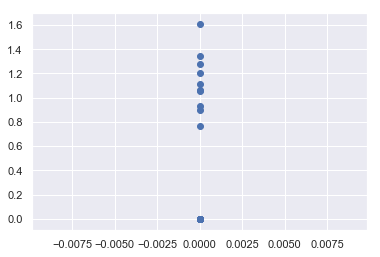

layer 10:


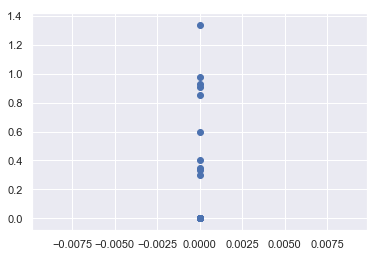

In [21]:
run_ggcn(drop=0.2, bias=True)